In [71]:
import os
import sys
import pandas
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from PIL import Image
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import Dataset
from collections import Counter
import random
torch.random.manual_seed(535)

In [72]:
default_data_dir = "/s/bach/b/class/cs535/cs535a"
DATA_DIR = os.getenv('TP_DATADIR',default_data_dir)

print("Using {} for Data Directory".format(DATA_DIR))

covid_dir = os.path.join(DATA_DIR,"covid-chest-xray")
covid_metadata = os.path.join(covid_dir,"metadata.csv")


covid_df = pandas.read_csv(covid_metadata)

Using /s/bach/b/class/cs535/cs535a for Data Directory


In [88]:
class CovidDataset(Dataset):
    def __init__(self, root_dir, image_df, transform=None, oversample=False,oversample_transform=None):
        xrays = set(image_df[image_df['modality'] == 'X-ray']['filename'].values)
        files = set(os.listdir(root_dir))
        self.filenames = list(files.intersection(xrays))
        
        self.orig_len = len(self.filenames)
        self.root_dir = root_dir
        self.oversample = oversample
        self.oversample_transform = oversample_transform
        self.oversamples = []
        self.transform = transform
        self.classVec = torch.zeros(2)
        self.lookup = {}
        filenames = image_df[['filename','finding']]
        
        for idx,row in filenames.iterrows():
            if row['filename'] not in self.filenames:
                continue
            self.lookup[row['filename']] = 0 if 'covid' in row['finding'].lower() else 1
            
        if oversample:
            self.choose_oversamples()
            
    def choose_oversamples(self):
        oversamples = []
        class_sizes = Counter(self.lookup.values())
        mc = class_sizes.most_common(1)[0]
        for classKey in class_sizes.keys():
            if classKey == mc[0]: # most common class
                continue
            num_short = mc[1] - class_sizes[classKey]
            target = [k for k,v in self.lookup.items() if v == classKey]
            for i in range(num_short):
                oversamples.append(random.choice(target))
                
        self.oversamples = oversamples
                
    def __len__(self):
        return len(self.filenames) + len(self.oversamples)

    def __getitem__(self, idx):
        if idx < self.orig_len:
            filename = self.filenames[idx]
        else:
            ov_index = idx - self.orig_len
            filename = self.oversamples[ov_index]
            
        img_name = os.path.join(self.root_dir, filename)
        #classVec = copy.deepcopy(self.classVec)
        classIndex = self.lookup[filename]
        #classVec[index] = 1

        # need "multi" one hot for BCE
        image = Image.open(img_name)
        
        if self.oversample_transform:
            image = self.oversample_transform(image)

        if self.transform:
            image = self.transform(image)

        
        return image, classIndex

    

In [89]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),
        transforms.Grayscale(3),
        transforms.Resize([224,224]),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ]),
    'oversample': transforms.Compose([
        transforms.Grayscale(3),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomApply([transforms.ColorJitter(0.4,0.4,0.4)])
       
        
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(3),
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])
}

image_dir = os.path.join(covid_dir,'images')
test_dir = os.path.join(covid_dir,'test')

covid_img_dataset = CovidDataset(image_dir,covid_df,data_transforms['train'],oversample=True,oversample_transform=data_transforms['oversample'])
test_img_dataset = CovidDataset(test_dir,covid_df,data_transforms['test'])

hold_out_size = int(len(covid_img_dataset) * 0.15)

train_set, val_set = torch.utils.data.random_split(covid_img_dataset,[len(covid_img_dataset)-hold_out_size, hold_out_size])

image_datasets = {'train':train_set,'val':val_set,'test':test_img_dataset}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Dataset sizes: {dataset_sizes}")
print(device)

Dataset sizes: {'train': 313, 'val': 55, 'test': 45}
cuda:0


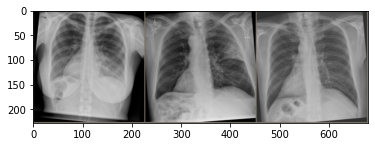

In [90]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

    

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:3])

imshow(out)

In [91]:
def evaluate_model(model):
    was_training = model.training
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            
            for j in range(inputs.size()[0]):
                correct_index = labels[j]
                pred_index = preds[j]
                if correct_index == pred_index:
                    correct += 1
                total += 1
                
        model.train(mode=was_training)
        
    return correct / total

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [92]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(covid_img_dataset.classVec))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8782 Acc: 0.5367
val Loss: 0.6084 Acc: 0.7636

Epoch 1/24
----------
train Loss: 0.6197 Acc: 0.6933
val Loss: 0.4723 Acc: 0.7455

Epoch 2/24
----------
train Loss: 0.7085 Acc: 0.6997
val Loss: 0.5511 Acc: 0.7091

Epoch 3/24
----------
train Loss: 0.5820 Acc: 0.7188
val Loss: 0.3586 Acc: 0.8545

Epoch 4/24
----------
train Loss: 0.4923 Acc: 0.7636
val Loss: 0.3900 Acc: 0.8364

Epoch 5/24
----------
train Loss: 0.9735 Acc: 0.6454
val Loss: 1.3722 Acc: 0.5636

Epoch 6/24
----------
train Loss: 0.7318 Acc: 0.7157
val Loss: 0.2831 Acc: 0.8909

Epoch 7/24
----------
train Loss: 0.3623 Acc: 0.8339
val Loss: 0.3608 Acc: 0.8182

Epoch 8/24
----------
train Loss: 0.3668 Acc: 0.8371
val Loss: 0.3869 Acc: 0.7636

Epoch 9/24
----------
train Loss: 0.3752 Acc: 0.8371
val Loss: 0.2683 Acc: 0.9273

Epoch 10/24
----------
train Loss: 0.3692 Acc: 0.8371
val Loss: 0.2840 Acc: 0.8909

Epoch 11/24
----------
train Loss: 0.3247 Acc: 0.8658
val Loss: 0.3348 Acc: 0.8364

Ep

In [93]:
evaluate_model(model_ft)

0.8